# Business Understanding: NBA Last 2 Minute Analysis

Over the years, the relationship between the referees and the players in the National Basketball Association (NBA) has come to impasse. The players and coaches believe the referees are affecting the outcome of the games and showing bias. Players and coaches’ sentiment have also reached into the fan base where the fans are taking issues on how the games are being called by the referees. The NBA decided to implement the last two-minute report to help protect the integrity of the game. This report provides an assessment of officiated events that occurred in the last two minutes for every game that were at or within three points during any points of the last two minutes of the fourth quarter and overtime. The plays assessed include all calls and all notable non calls. Non calls are defined as material plays directly related to the outcome of a possession. This report was the NBA's first step to total transparency. The main outcome that the NBA is concerned with is whether the referees got the call right in the realms of the rules. 

Our teams's analysis will focus on determining whether there is bias towards particular players or teams for referee calls during the previously mentioned last two minutes. We will be augmenting our base data set with additional attributes indicating whethere a player's status is all-star or not. Are all-star players treated differently? Do officials have a tendency to get more calls right or wrong when it comes to all-star players? Answering these questions can help with training and teaching of referees of their biases.

In [27]:
# Import initial libraries 
import numpy as np
import pandas as pd

# Visulization libraries
import matplotlib as plt
%matplotlib inline
import seaborn as sns

import warnings 
warnings.simplefilter('ignore', DeprecationWarning)

# Data Meaning Type 

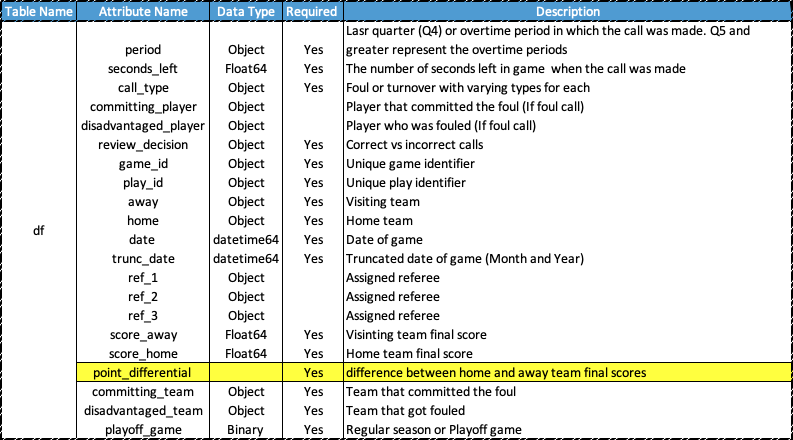

We determined some variables were not needed for this analysis so they were elimnated before subsequent data wrangling efforts.
- **time**: time of call or non call, will use seconds remained column instead
- **video**: web link to a video of call or non call, not relevant to analysis
- **original_pdf**: pdf file name, not relevant to analysis
- **box_score_url**: url, scores are already in separate columns
- **comment**: text describing the violation, we will not be performing any NLP in this analysis
- **ref_made_call**: names only exist in 0.8% of the data, will use columns indicating refs that officiated the game

In [64]:
# Import data
df = pd.read_csv("data/all_games.csv")

# drop unecessary columns 
df = df.drop(columns=['time','video','original_pdf','box_score_url','comment','ref_made_call'], axis=1)

#df.head()

In [65]:
df.head()

,Index,period,seconds_left,call_type,committing_player,disadvantaged_player,review_decision,game_id,play_id,away,...,Foul,Instant Replay,Other,Turnover,Violation,OT,10Sec,allstar,c_playerid,d_playerid
0,10000,Q4,112.0,Foul: Shooting,Josh Smith,Kevin Love,CNC,20150301CLEHOU,20150301CLEHOU-0,CLE,...,1.0,0.0,0.0,0.0,0.0,0,0,0,2746.0,201567.0
1,10001,Q4,103.0,Foul: Shooting,J.R. Smith,James Harden,CC,20150301CLEHOU,20150301CLEHOU-1,CLE,...,1.0,0.0,0.0,0.0,0.0,0,0,0,2747.0,201935.0
2,10002,Q4,92.0,Foul: Shooting,Trevor Ariza,LeBron James,CC,20150301CLEHOU,20150301CLEHOU-2,CLE,...,1.0,0.0,0.0,0.0,0.0,0,0,0,2772.0,2544.0
3,10003,Q4,69.0,Foul: Loose Ball,Terrence Jones,Tristan Thompson,CC,20150301CLEHOU,20150301CLEHOU-3,CLE,...,1.0,0.0,0.0,0.0,0.0,0,0,0,203093.0,202684.0
4,10004,Q4,53.0,Foul: Shooting,Tristan Thompson,Josh Smith,CNC,20150301CLEHOU,20150301CLEHOU-4,CLE,...,1.0,0.0,0.0,0.0,0.0,0,0,0,202684.0,2746.0


Our initial dataset has a total of 26,822 records with 18 attributes. 

In [66]:
df.shape

(26822, 29)

# Data Quality

Let's check the uniqueness of the **review_decision** field. We expect to see only the following codes: 
- CC = correct call 
- CNC = correct non-call
- IC = incorrect call
- INC = incorrect non-call.

There are 44 records with player names misplaced, so the team decided to remove them altogether given the represent such a small percentage of the total dataset. 

In [30]:
# Check valid unique values per column
df.groupby('review_decision')['review_decision'].count().sort_values(ascending=False)

review_decision
CNC                 15448
CC                   7412
INC                  1957
IC                    240
Damian Lillard          6
Ricky Rubio             4
Marcin Gortat           4
Bradley Beal            3
Mario Chalmers          3
Terrence Ross           3
Thabo Sefolosha         2
Jerryd Bayless          2
CJ McCollum             2
Jonathon Simmons        2
Marc Gasol              2
Nikola Vucevic          2
Ben Simmons             2
Joe Ingles              1
JJ Redick               1
Jusuf Nurkic            1
Kelly Oubre Jr.         1
Maurice Harkless        1
Robert Covington        1
Shelvin Mack            1
Name: review_decision, dtype: int64

There seem to be some invalid values in the 'period' column as well. For example, this column should only contain values Q4 and great, but there is a value listed as 'Q3'. This doesn't make sense given this data is from the 2 minute report. There are only 2 records affected so we decided to remove them from our dataset. Anything greater than Q4 is overtime.

In [31]:
df.groupby('period')['period'].count().sort_values(ascending=False)

period
Q4    22488
Q5     3831
Q6      409
Q7       56
Q8       36
Q3        2
Name: period, dtype: int64

In [32]:
# Remove invalid rows that show player names in the review_decision column
df = df.loc[(df['review_decision']=='CNC') | (df['review_decision']=='CC') | (df['review_decision']=='INC')
      | (df['review_decision']=='IC')]

# remove the rows that do not include valid values for the review_decision column, create df2 with results
# df = df[df.review_decision.isin([x for x in df.review_decision if x in ['CC','CNC','IC','INC']])]

# Remove invalid Q3 rows from period column. Final 2 min report should not include plays in the 3rd quarter 
df = df[df.period != 'Q3']

Let's check to ensure the incorrect values were indeed removed.

In [33]:
print(df.groupby('review_decision')['review_decision'].count())

review_decision
CC      7412
CNC    15446
IC       240
INC     1957
Name: review_decision, dtype: int64


In [34]:
print(df.groupby('period')['period'].count())

period
Q4    20956
Q5     3630
Q6      382
Q7       54
Q8       33
Name: period, dtype: int64


#### NaN Check

The "disadvantaged_player" column has the majority of missing values in this dataframe. We know that not all of these entries are fouls so it would make sense there are no "committing_team", "disadvantaged_team", "committing_player" or "disadvantaged_player" in some instances. However, there should always be at least 1 referee per contest. Let's dig deeper...

In [35]:
# Missing values sort descending
df_percent = df.isna().sum()/len(df)*100 # Percent of total 'NaN' rows by column
df_percent.sort_values(ascending=False)

disadvantaged_player    11.754141
committing_team          5.986829
disadvantaged_team       5.986829
committing_player        5.491918
ref_3                    0.498902
ref_2                    0.207543
ref_1                    0.207543
score_home               0.131710
score_away               0.131710
review_decision          0.000000
seconds_left             0.000000
call_type                0.000000
away                     0.000000
game_id                  0.000000
play_id                  0.000000
home                     0.000000
date                     0.000000
period                   0.000000
dtype: float64

xxxxxxxx

In [36]:
df_NoNaN = df.dropna(subset=['ref_1','ref_2','ref_3'], thresh=1) 

In [37]:
# Create new dataframe with NaN rows removed
# Only remove NA values that are in the columns listed in the subset. If at least 1 NaN then remove
# Still need to handle ref_1, ref_2, ref_3 columns differently. Delete rows if all 3 ref columns are missing 
df_NoNaN = df.dropna(subset=['disadvantaged_player','review_decision','committing_player',
                            'score_home','score_away','call_type']) 

# comparing NEW (df) vs OLD (df2) dataframes 
print("Old data frame length:", len(df), "\nNew data frame length:",  
       len(df_NoNaN), "\nNumber of rows with at least 1 NA value: ", 
       (len(df)-len(df_NoNaN)),"\nPercent of total rows lost to NA values:",
     (len(df)-len(df_NoNaN))/len(df))

Old data frame length: 25055 
New data frame length: 25003 
Number of rows with at least 1 NA value:  52 
Percent of total rows lost to NA values: 0.0020754340451007783


In [40]:
df = df_NoNaN

# New Features

We will identify new features here and perform simple statistics on all features later.

#### Point Differential

There may be value in creating a point differential column between the home and away scores allowing us to potentially reduce the number of variables in our dataset. We won't know for sure until we investigate further, but we will add it  to our dataframe in advance. 

In [46]:
df['point_diff'] = df['score_home']-df['score_away']

#### Date Transformation/Fields

There may be value in using the date column to explore our data and look at things like referee performance over time and other trended insights. In order to do this we must convert the date field from from a integer variable type to datetime so we may access date attributes in subsequent analysis.

In [47]:
# Add some date functions

# Convert date from int64 to datetime column
df['date'] = pd.to_datetime(df['date'].astype(str), format='%Y-%m-%d', errors='raise')

# Truncate date to represent month and year only
df['trunc_date'] = df['date'].values.astype('datetime64[M]')

# Create month and year column as string
df['month_year'] = df['date'].dt.to_period('M')

#### Review Decision - Numeric Codes

Next we will create code mappings for the review_decision field. CC  = 0, CNC = 1, IC = 2, INC = 3

In [48]:
# create new column of coded review_decisions
df['review_decision_code']=df.review_decision.astype("category").cat.codes

#### Field for Good and Bad Calls

In [49]:
# add a column for good/bads calls where (CC & CNC) = 1, bad calls (IC & INC) = 0
df['good_bad'] = np.where((df['review_decision']=='CC') | (df['review_decision']=='CNC'), 1, 0)

#### Game Type (Regular Season vs Post Season)

In [50]:
# add a column for game type where regular season = 1, post season = 2

# create playoff date range
playoff_start2015=pd.to_datetime('2015-4-18', format='%Y-%m-%d', errors='raise')
playoff_stop2015=pd.to_datetime('2015-06-16', format='%Y-%m-%d', errors='raise')
playoff_start2016=pd.to_datetime('2016-4-16', format='%Y-%m-%d', errors='raise')
playoff_stop2016=pd.to_datetime('2016-05-30', format='%Y-%m-%d', errors='raise')
playoff_start2017=pd.to_datetime('2017-4-15', format='%Y-%m-%d', errors='raise')
playoff_stop2017=pd.to_datetime('2017-06-12', format='%Y-%m-%d', errors='raise')
playoff_start2018=pd.to_datetime('2018-4-14', format='%Y-%m-%d', errors='raise')
playoff_stop2018=pd.to_datetime('2018-06-08', format='%Y-%m-%d', errors='raise')

def playoff_status (game): 
    if ((playoff_start2015 <= game <= playoff_stop2015) 
      | (playoff_start2016 <= game <= playoff_stop2016)
      | (playoff_start2017 <= game <= playoff_stop2017)
      | (playoff_start2018 <= game <= playoff_stop2018)) :
        return 'regular'
    return 'post'

df['game_type']=df['date'].apply(playoff_status)

#### Season Field 

In [51]:
# add a column for season

# create playoff date range
season_start2014_15=pd.to_datetime('2014-10-28', format='%Y-%m-%d', errors='raise')
season_stop2014_15=pd.to_datetime('2015-06-16', format='%Y-%m-%d', errors='raise')
season_start2015_16=pd.to_datetime('2015-10-27', format='%Y-%m-%d', errors='raise')
season_stop2015_16=pd.to_datetime('2016-05-30', format='%Y-%m-%d', errors='raise')
season_start2016_17=pd.to_datetime('2016-10-25', format='%Y-%m-%d', errors='raise')
season_stop2016_17=pd.to_datetime('2017-06-18', format='%Y-%m-%d', errors='raise')
season_start2017_18=pd.to_datetime('2017-10-17', format='%Y-%m-%d', errors='raise')
season_stop2017_18=pd.to_datetime('2018-06-08', format='%Y-%m-%d', errors='raise')

def get_season (game): 
    if (season_start2014_15 <= game <= season_stop2014_15) :
        return '2014-15'
    if (season_start2015_16 <= game <= season_stop2015_16) :
        return '2015-16'
    if (season_start2016_17 <= game <= season_stop2016_17) :
        return '2016-17'
    if (season_start2017_18 <= game <= season_stop2017_18) :
        return '2017-18'
    return 'CheckMe'

df['season']=df['date'].apply(get_season)

#### Allstar Players
Allstars are based off wikipedia

Reference: https://en.wikipedia.org/wiki/List_of_NBA_All-Stars

In [55]:
# read allstar data previously pulled from https://en.wikipedia.org/wiki/List_of_NBA_All-Stars
allstars_df = pd.read_csv("data/allstars.csv")

# confirm allstar file read
allstars_df.head()

,AllStar
0,Kareem Abdul-Jabbar
1,Kobe Bryant
2,Tim Duncan
3,Kevin Garnett
4,LeBron James


Creating two allstar fields for the committing and disadvantaged player.

In [57]:
# add a column for allstar player, allstar = 1, not an allstar = 0
df['commit_allstar'] = np.where(df['committing_player'].isin(allstars_df['AllStar']).astype(int), 1, 0)

# add a column for allstar player, allstar = 1, not an allstar = 0
df['disadv_allstar'] = np.where(df['disadvantaged_player'].isin(allstars_df['AllStar']).astype(int), 1, 0)

In [23]:
print(df['call_type'].value_counts())

Foul: Personal                       7626
Foul: Shooting                       6999
Foul: Offensive                      4776
Foul: Loose Ball                     2331
Turnover: Traveling                  1381
Instant Replay: Support Ruling        840
Foul: Defense 3 Second                423
Foul: Personal Take                   318
Turnover: 3 Second Violation          290
Instant Replay: Overturn Ruling       282
Turnover: 24 Second Violation         181
Turnover: 5 Second Inbound            164
Violation: Lane                       132
Foul: Away from Play                  116
Turnover: Stepped out of Bounds       105
Stoppage: Out-of-Bounds                99
Violation: Defensive Goaltending       94
Violation: Kicked Ball                 82
Foul: Technical                        62
Turnover: Backcourt Turnover           54
Turnover: Double Dribble               43
Turnover: Offensive Goaltending        40
Violation: Delay of Game               39
Foul: Inbound                     

In [48]:
import re

def call_type_grp():
    if re.search('^F'):
        return 'Foul'
    elif re.search('^T'):
        return 'Turnover'
    elif re.search('^V'):
        return 'Violation'
    else: 
        return 'Other'

In [ ]:
def call_type_grp(x):
    if x == re.search('^F',):
        return 'Foul'
    elif x == re.search('^T',):
        return 'Turnover'
    elif x == re.search('^V',):
        return 'Violation'
    elif x == re.search('^I',):
        return 'InstantReplay'
    else: return 'Other'

In [ ]:
df.loc[df['A'] == df['B'], 'C'] = 0
df.loc[df['A'] > df['B'], 'C'] = 1
df.loc[df['A'] < df['B'], 'C'] = -1

In [49]:
df['call_type_grp'] = df.apply(call_type_grp, axis=1)

TypeError: ('call_type_grp() takes 0 positional arguments but 1 was given', 'occurred at index 0')

In [59]:
df.head(100)

,period,seconds_left,call_type,committing_player,disadvantaged_player,review_decision,game_id,play_id,away,home,...,committing_team,point_diff,review_decision_code,trunc_date,month_year,good_bad,game_type,season,commit_allstar,disadv_allstar
0,Q4,112.0,Foul: Shooting,Josh Smith,Kevin Love,CNC,20150301CLEHOU,20150301CLEHOU-0,CLE,HOU,...,HOU,2.0,1,2015-03-01,2015-03,1,post,2014-15,0,1
1,Q4,103.0,Foul: Shooting,J.R. Smith,James Harden,CC,20150301CLEHOU,20150301CLEHOU-1,CLE,HOU,...,CLE,2.0,0,2015-03-01,2015-03,1,post,2014-15,0,1
2,Q4,92.0,Foul: Shooting,Trevor Ariza,LeBron James,CC,20150301CLEHOU,20150301CLEHOU-2,CLE,HOU,...,HOU,2.0,0,2015-03-01,2015-03,1,post,2014-15,0,1
3,Q4,69.0,Foul: Loose Ball,Terrence Jones,Tristan Thompson,CC,20150301CLEHOU,20150301CLEHOU-3,CLE,HOU,...,HOU,2.0,0,2015-03-01,2015-03,1,post,2014-15,0,0
4,Q4,53.0,Foul: Shooting,Tristan Thompson,Josh Smith,CNC,20150301CLEHOU,20150301CLEHOU-4,CLE,HOU,...,CLE,2.0,1,2015-03-01,2015-03,1,post,2014-15,0,0
5,Q4,29.1,Foul: Shooting,Terrence Jones,LeBron James,CNC,20150301CLEHOU,20150301CLEHOU-5,CLE,HOU,...,HOU,2.0,1,2015-03-01,2015-03,1,post,2014-15,0,1
6,Q5,274.0,Foul: Shooting,Tristan Thompson,Terrence Jones,CC,20150301CLEHOU,20150301CLEHOU-6,CLE,HOU,...,CLE,2.0,0,2015-03-01,2015-03,1,post,2014-15,0,0
7,Q5,274.0,Instant Replay: Support Ruling,NaN,NaN,CC,20150301CLEHOU,20150301CLEHOU-7,CLE,HOU,...,NaN,2.0,0,2015-03-01,2015-03,1,post,2014-15,0,0
8,Q5,245.0,Foul: Personal,LeBron James,James Harden,CNC,20150301CLEHOU,20150301CLEHOU-8,CLE,HOU,...,CLE,2.0,1,2015-03-01,2015-03,1,post,2014-15,1,1
9,Q5,234.0,Foul: Double Personal,LeBron James,James Harden,INC,20150301CLEHOU,20150301CLEHOU-9,CLE,HOU,...,CLE,2.0,3,2015-03-01,2015-03,0,post,2014-15,1,1


# Simple Statistics 

In [60]:
# calls by season
df.groupby('season')['review_decision'].value_counts()

season   review_decision
2014-15  CNC                 889
         CC                  819
         INC                 230
         IC                   26
2015-16  CNC                3395
         CC                 2414
         INC                 645
         IC                  111
2016-17  CNC                4180
         CC                 2031
         INC                 545
         IC                   39
2017-18  CNC                6951
         CC                 2133
         INC                 531
         IC                   64
Name: review_decision, dtype: int64

# Visualize Attributes 

# Explore Joint Attributes and Class 

### NBA_api Connection Attemps

In [36]:
# Get dataframe of all players and player id's

from nba_api.stats.static import players
# get_players returns a list of dictionaries, each representing a player.
nba_players = players.get_players()

# Convert dictionary to dataframe
df_nba_players = pd.DataFrame.from_dict(nba_players)

df_nba_players.head()

,first_name,full_name,id,is_active,last_name
0,Alaa,Alaa Abdelnaby,76001,False,Abdelnaby
1,Zaid,Zaid Abdul-Aziz,76002,False,Abdul-Aziz
2,Kareem,Kareem Abdul-Jabbar,76003,False,Abdul-Jabbar
3,Mahmoud,Mahmoud Abdul-Rauf,51,False,Abdul-Rauf
4,Tariq,Tariq Abdul-Wahad,1505,False,Abdul-Wahad


In [21]:
# Create list of player id's needed to pass through endpoint 
player_id_list = df_nba_players['id'].unique().tolist()

In [38]:
# Get game specific stats with player_id and game_id

#playergamelog require playter id in api request
from nba_api.stats.endpoints import playergamelog 

nba_gamelogs = playergamelog.PlayerGameLog(player_id='203076', season='2018-19',
                                             season_type_all_star='Regular Season')

#Return dataframe
nba_gamelogs.get_data_frames()

[   SEASON_ID  Player_ID     Game_ID     GAME_DATE      MATCHUP WL  MIN  FGM  \
 0      22018     203076  0021801099  MAR 24, 2019  NOP vs. HOU  L   21    6   
 1      22018     203076  0021801056  MAR 18, 2019    NOP @ DAL  W   21    8   
 2      22018     203076  0021801036  MAR 16, 2019  NOP vs. PHX  L   22    6   
 3      22018     203076  0021801010  MAR 12, 2019  NOP vs. MIL  L   21    9   
 4      22018     203076  0021800995  MAR 10, 2019    NOP @ ATL  L   21    6   
 5      22018     203076  0021800971  MAR 06, 2019  NOP vs. UTA  L   21    6   
 6      22018     203076  0021800956  MAR 04, 2019    NOP @ UTA  W   22    7   
 7      22018     203076  0021800932  MAR 01, 2019    NOP @ PHX  W   21    7   
 8      22018     203076  0021800921  FEB 27, 2019    NOP @ LAL  L   21   10   
 9      22018     203076  0021800906  FEB 25, 2019  NOP vs. PHI  L   21    8   
 10     22018     203076  0021800874  FEB 22, 2019    NOP @ IND  L   20    6   
 11     22018     203076  0021800866  FE

### Duplicates 

In [31]:
# Which player_id should we use for duplicate records?
# Check to see which players and how many times duplicated.

print("Duplicate Summary:",
      "\nNumber of duplicate id:", df_nba_players.duplicated(['id']).sum(),
      "\nNumber of duplicate full_name:", df_nba_players.duplicated(['full_name']).sum(),
      "\nNumber of duplicate id AND full_name:", df_nba_players.duplicated(['id','full_name']).sum(),
      "\nNumber of duplicate rows:", df_nba_players.duplicated().sum())


Duplicate Summary: 
Number of duplicate id: 0 
Number of duplicate full_name: 36 
Number of duplicate id AND full_name: 0 
Number of duplicate rows: 0


In [36]:
# Create dataframe Only keep last player_id, full_name row/record

# df_nba_players_deftable_1 = df_nba_players.drop_duplicates(['full_name'], keep='last', inplace=False)

# df_nba_players_deftable_1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4357 entries, 0 to 4392
Data columns (total 5 columns):
first_name    4357 non-null object
full_name     4357 non-null object
id            4357 non-null int64
is_active     4357 non-null bool
last_name     4357 non-null object
dtypes: bool(1), int64(1), object(3)
memory usage: 174.5+ KB


In [40]:
df_nba_players['full_name'].unique()

array(['Alaa Abdelnaby', 'Zaid Abdul-Aziz', 'Kareem Abdul-Jabbar', ...,
       'Bill Zopf', 'Ivica Zubac', 'Matt Zunic'], dtype=object)

In [61]:
# Need to join id to original dataframe. 
# Need to use some combination of player_id and game_id to merge individual player states for that game


#df_nba_players['full_name'].value_counts()
#df_nba_players.groupby['full_name'].value_counts()

test = df_nba_players.groupby('full_name')

print(test.filter(lambda x: x['full_name'].value_counts()>1))

     first_name         full_name       id  is_active  last_name
482         Dee         Dee Brown      244      False      Brown
483         Dee         Dee Brown   200793      False      Brown
887     Charlie     Charlie Davis    76518      False      Davis
888     Charlie     Charlie Davis    76519      False      Davis
902        Mark        Mark Davis      707      False      Davis
903        Mark        Mark Davis    76528      False      Davis
1041        Bob         Bob Duffy    76609      False      Duffy
1042        Bob         Bob Duffy    76610      False      Duffy
1051       Mike     Mike Dunleavy     2399      False   Dunleavy
1052       Mike     Mike Dunleavy    76616      False   Dunleavy
1159    Patrick     Patrick Ewing      121      False      Ewing
1160    Patrick     Patrick Ewing   201607      False      Ewing
1522       Matt       Matt Guokas    76908      False     Guokas
1523       Matt       Matt Guokas    76909      False     Guokas
1671     Cedric  Cedric H

In [52]:
#df['committing_player_v2'] = df['committing_player'].astype(str)

In [8]:
df = pd.merge(df, df_nba_players[['id']], left_on='committing_player', right_on='full_name', how='left')

KeyError: 'full_name'